In [1]:
import rsatoolbox as rsa
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

plt.close('all')
plt.style.use('default')

# Add the parent directory to sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_path not in sys.path:
    sys.path.append(project_path)

import globals as gl



Base directory found: /cifs/diedrichsen/data/Chord_exp/ExtFlexChord


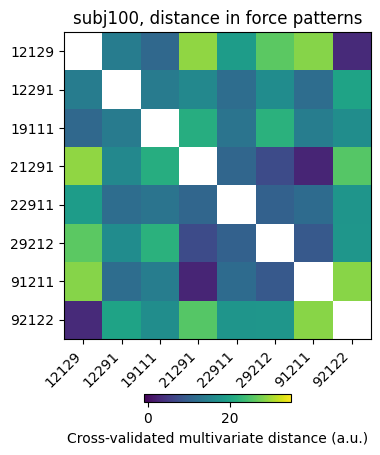

In [2]:
experiment = 'efc4'

vmin, vmax = -1, 35
participant_id='subj100'

fig, axs = plt.subplots()

rdms = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1', participant_id, f'force.hdf5'))

cax = rsa.vis.show_rdm_panel(
                rdms, axs, rdm_descriptor='roi', cmap='viridis', vmin=vmin, vmax=vmax
            )

axs.set_xticks(np.arange(len(rdms.pattern_descriptors['conds'])))
axs.set_xticklabels(rdms.pattern_descriptors['conds'], rotation=45, ha='right')
axs.set_yticks(axs.get_xticks())
axs.set_yticklabels(rdms.pattern_descriptors['conds'])
axs.set_title(f'{participant_id}, distance in force patterns')

cbar = fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=.02)
cbar.set_label('Cross-validated multivariate distance (a.u.)')


plotting...glm3.L.SMA.hdf5
plotting...glm3.L.PMd.hdf5
plotting...glm3.L.PMv.hdf5
plotting...glm3.L.M1.hdf5
plotting...glm3.L.S1.hdf5
plotting...glm3.L.SPLa.hdf5
plotting...glm3.L.SPLp.hdf5
plotting...glm3.L.V1.hdf5


Text(0.5, 0.98, 'participant:subj100, hemisphere:L')

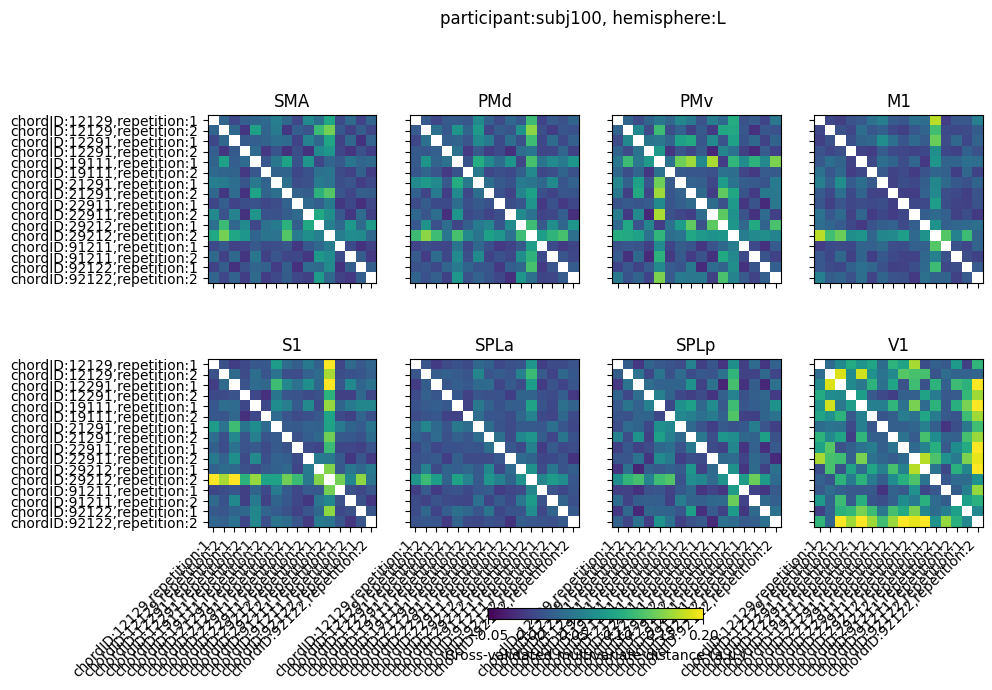

In [9]:
roi = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']

experiment = 'efc4'

Hem = 'L'
r = 0
glm = 3
vmin, vmax = -.05, .2
participant_id='subj100'
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10, 7))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        print(f'plotting...glm{glm}.{Hem}.{roi[r]}.hdf5')
        rdms = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1',participant_id,f'glm{glm}.{Hem}.{roi[r]}.hdf5'))

        cax = rsa.vis.show_rdm_panel(
                rdms, axs[i, j], rdm_descriptor='roi', cmap='viridis', vmin=vmin, vmax=vmax
            )
        axs[i, j].set_xticks(np.arange(len(rdms.pattern_descriptors['conds'])))
        axs[i, j].set_xticklabels(rdms.pattern_descriptors['conds'], rotation=45, ha='right')
        axs[i, j].set_yticks(axs[i, j].get_xticks())
        axs[i, j].set_yticklabels(rdms.pattern_descriptors['conds'])
        axs[i, j].set_title(roi[r])

        # axs[i, j].axhline(0, color='k', ls='-', lw=.8)
        # axs[i, j].axvline(0, color='k', ls='-', lw=.8)
        r += 1

cbar = fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=.02)
cbar.set_label('Cross-validated multivariate distance (a.u.)')
fig.suptitle(f'participant:{participant_id}, hemisphere:{Hem}')

Text(0.5, 1.0, 'Correlation between cross-validated multivariate distance\nin force vs. fMRI activity')

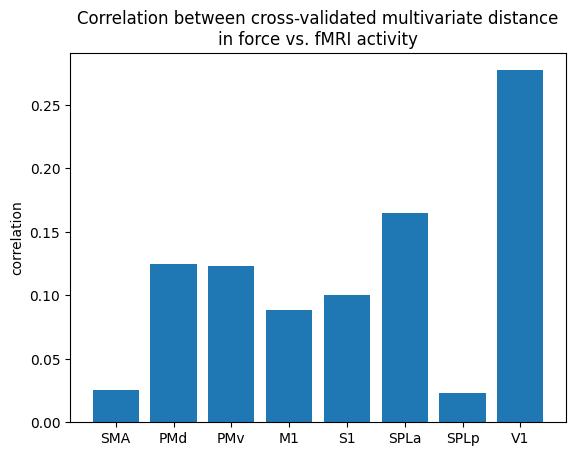

In [4]:
rois = ['SMA', 'PMd', 'PMv', 'M1', 'S1', 'SPLa', 'SPLp', 'V1']

experiment = 'efc4'

Hem = 'L'
r = 0
glm = 2

participant_id='subj100'

rdm_force = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1', participant_id, f'force.hdf5'))
dforce = rdm_force.dissimilarities

corr = list()

for roi in rois:
        rdm_roi = rsa.rdm.load_rdm(os.path.join(gl.baseDir, experiment, gl.rdmDir, 'day1',participant_id,f'glm{glm}.{Hem}.{roi}.hdf5'))
        droi = rdm_roi.dissimilarities
        
        corr.append(np.corrcoef(droi, dforce)[0, 1])
        
corr = np.array(corr)

fig, axs = plt.subplots()

axs.bar(rois, corr)
axs.set_ylabel('correlation')

axs.set_title('Correlation between cross-validated multivariate distance\nin force vs. fMRI activity')

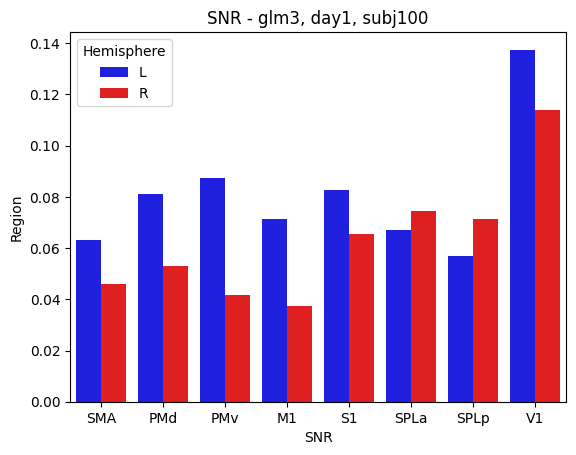

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from variance_decomposition import within_subj_var

# Define parameters
experiment = 'efc4'
glm = 3
sn = 100
day = 1

# Storage for SNR values
snr_data = []

# Iterate through hemispheres and ROIs
for Hem in ['L', 'R']:
    for roi in gl.rois['ROI']:
        # Load data
        Y = np.load(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', f'ROI.{Hem}.{roi}.beta.npy'))
        res = np.load(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', f'ROI.{Hem}.{roi}.res.npy'))

        # Prewhitening
        # Y = Y / np.sqrt(res)

        # Load partitioning and condition information
        reginfo = pd.read_csv(os.path.join(gl.baseDir, experiment, f'{gl.glmDir}{glm}', f'day{day}', f'subj{sn}', 'reginfo.tsv'), sep='\t')
        partition_vec = reginfo.run
        cond_vec = reginfo.name

        # Compute variance components
        v_s, v_se = within_subj_var(Y, partition_vec, cond_vec, subtract_mean=True)
        snr = v_s / v_se

        # Append to data list
        snr_data.append({'ROI': roi, 'Hemisphere': Hem, 'SNR': snr})

# Convert to DataFrame
snr_df = pd.DataFrame(snr_data)

# Pivot Data for Faceted Plot
fig, axs = plt.subplots()
sns.barplot(data=snr_df, y='SNR', x='ROI', hue='Hemisphere', palette={'L': 'blue', 'R': 'red'}, dodge=True, ax=axs)

# Formatting
axs.set_xlabel("SNR")
axs.set_ylabel("Region")
axs.set_title(f'SNR - glm{glm}, day{day}, subj{sn}')
axs.legend(title="Hemisphere")
plt.show()
